In [83]:
# 0. Import packages
import os
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 1. Create model


# USE RESIDUAL NEURAL NETWORKS AND FCN'S WITH 1X1 CONVOLUTIONS AND UPSAMPLING OPERATIONS
import torch

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6):
        super(UNet, self).__init__()

        # Downsampling (Encoder)
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv3 = self.double_conv(128, 256)

        # Upsampling (Decoder)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = self.double_conv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5 = self.double_conv(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        x3 = self.conv2(x2)
        x4 = self.pool2(x3)

        # Bottleneck
        x5 = self.conv3(x4)

        # Decoder with skip connections
        x6 = self.up1(x5)
        x6 = torch.cat([x3, x6], dim=1)
        x7 = self.conv4(x6)

        x8 = self.up2(x7)
        x8 = torch.cat([x1, x8], dim=1)
        x9 = self.conv5(x8)

        return self.final_conv(x9)

# Create model instance
model = UNet(in_channels=3, out_channels=3)
device = torch.device(0)
model.to(device)

print(model)


UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (up1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Sequential(
    (0): Conv2d(256, 128

In [85]:
# 2. Prepare data
IMAGE_PATH = "./image"
LABEL_PATH = "./label"

trainFiles = pd.read_csv("./train.csv", header=None)[0].tolist()
testFiles = pd.read_csv("./test.csv", header=None)[0].tolist()


def load_image(filename):
    """Load an RGB image and convert to a tensor"""
    img = Image.open(os.path.join(IMAGE_PATH, filename)).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
    ])
    return transform(img)  # Apply transform


def load_annotation(label_type, filename):
    """Load an indexed annotation as a tensor"""
    ann = Image.open(os.path.join(LABEL_PATH, label_type, filename)).convert('RGB')
    ann = ann.resize((512, 512), Image.NEAREST)  # Resize without interpolation
    return torch.tensor(np.array(ann), dtype=torch.float).permute(2, 1, 0)  # Keep as class index, not one-hot

class QuakeCityDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img = load_image(filename)
        # component = load_annotation("component", filename)
        crack = load_annotation("crack", filename)
        # spall = load_annotation("spall", filename)
        # rebar = load_annotation("rebar", filename)
        # ds = load_annotation("ds", filename)
        # depth = load_annotation("depth", filename)
        label = crack
        return img, label

# Create dataset and dataloader
train_dataset = QuakeCityDataset(trainFiles)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# Get a batch
img_batch, label_batch = next(iter(train_loader))
print("Batch image shape:", img_batch.shape)
print("Batch label shape:", label_batch.shape)


Batch image shape: torch.Size([8, 3, 512, 512])
Batch label shape: torch.Size([8, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


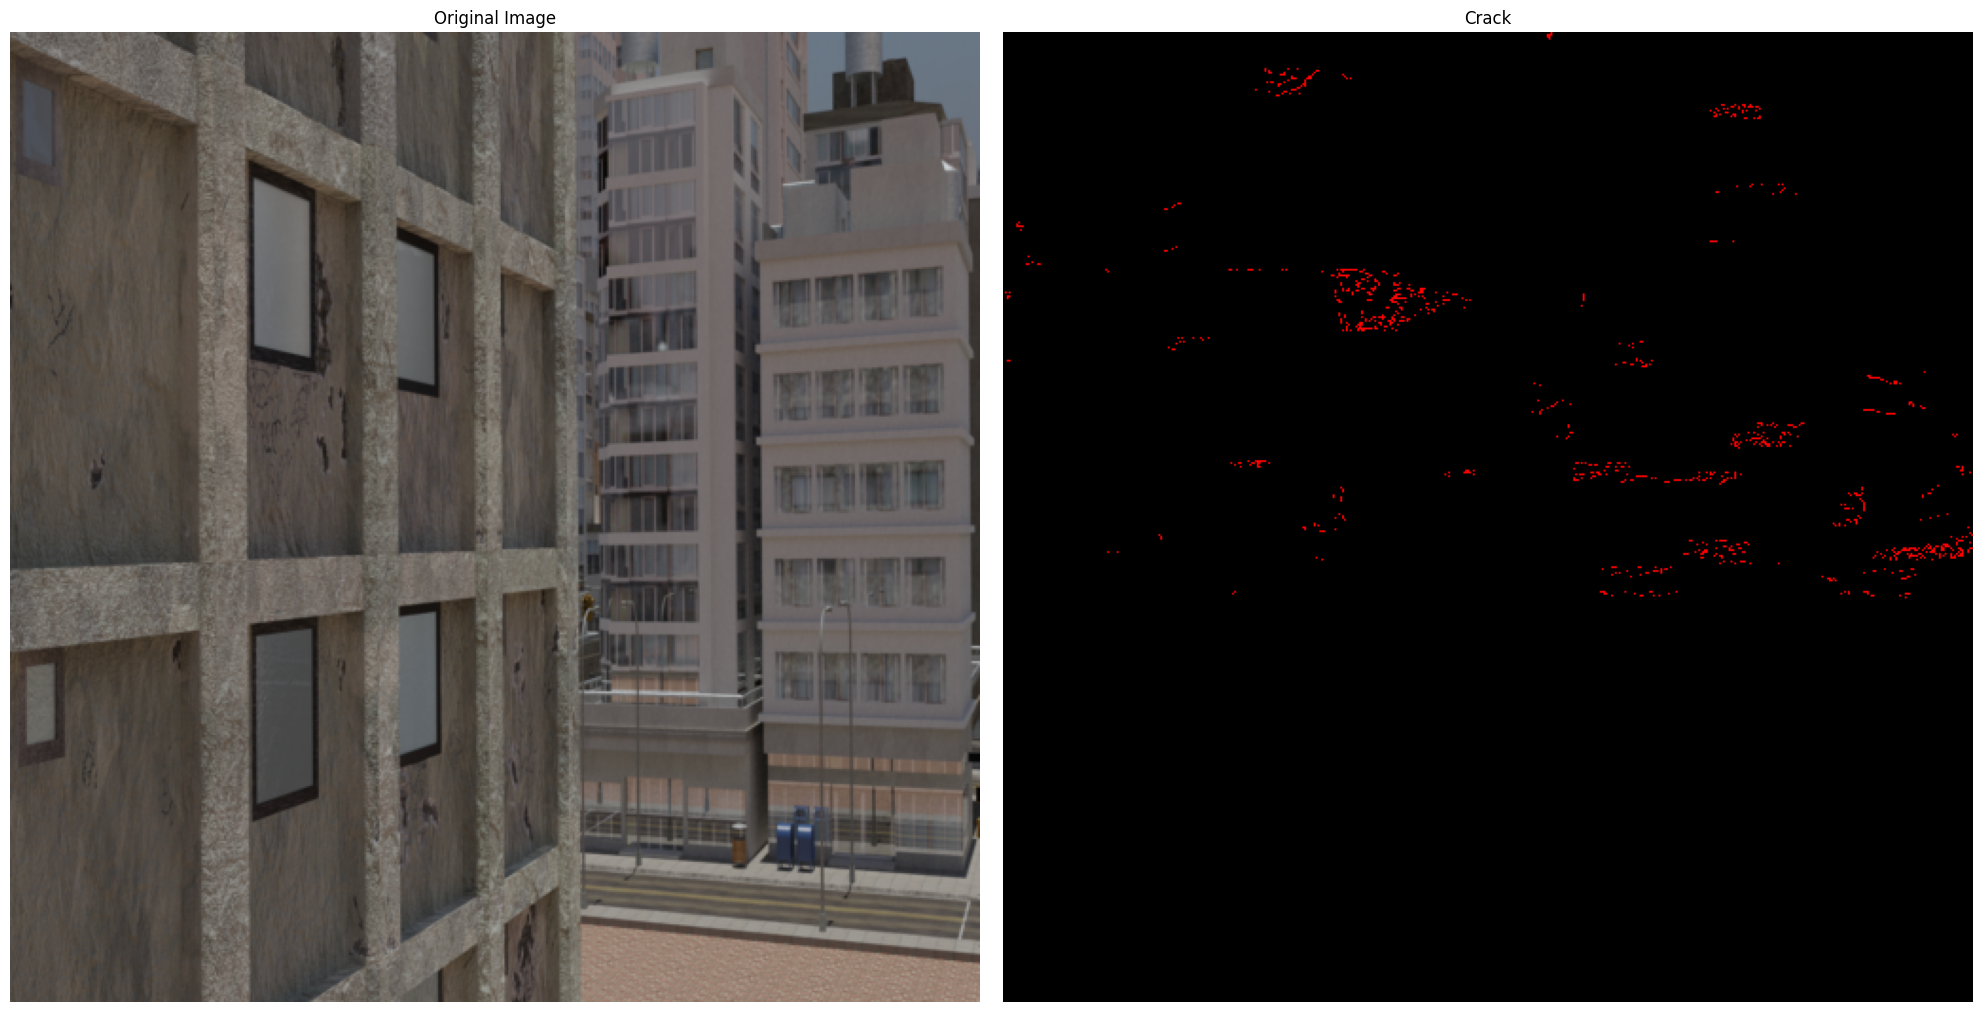

In [88]:
# 2.5 Visualise data
def visualize_sample(image, label):
    """Display the image and its 6 label masks."""
    label_names = ["Component", "Crack", "Spall", "Rebar", "Damage State", "Depth"]
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Show the original image
    axes[0].imshow(image.permute(1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    # Show the label mask
    axes[1].imshow(label.permute(1, 2, 0))  # Visualize label
    axes[1].set_title(label_names[1])
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

img_batch, label_batch = next(iter(train_loader))
visualize_sample(img_batch[0], label_batch[0])

In [87]:
# 3. Choose optimizer

criterion = nn.CrossEntropyLoss()  # Multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch  1: zero_grad(): loss= 4.9757 output_mean= 0.0399 target_mean= 1.5487


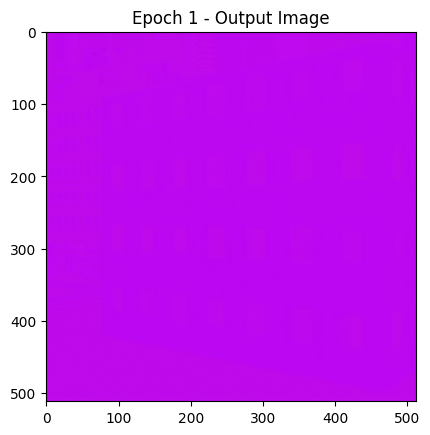

Epoch  1: zero_grad(): loss= 4.7387 output_mean= 0.0402 target_mean= 1.4750


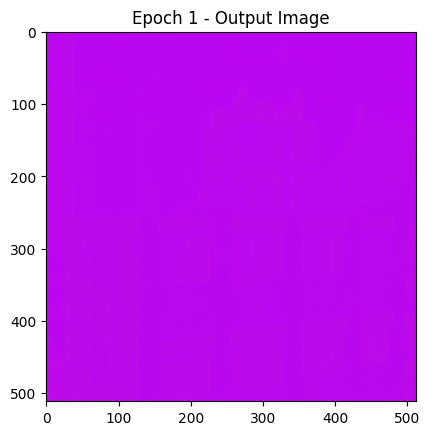

Epoch  1: zero_grad(): loss= 2.6360 output_mean= 0.0399 target_mean= 0.8207


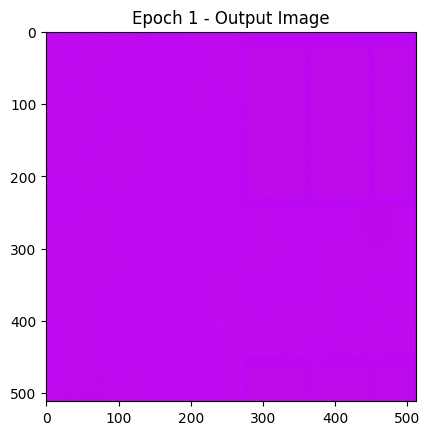

Epoch  1: zero_grad(): loss= 4.4385 output_mean= 0.0399 target_mean= 1.3813


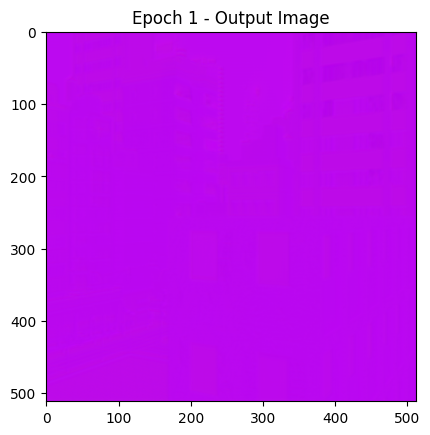

Epoch  1: zero_grad(): loss= 5.0184 output_mean= 0.0400 target_mean= 1.5620


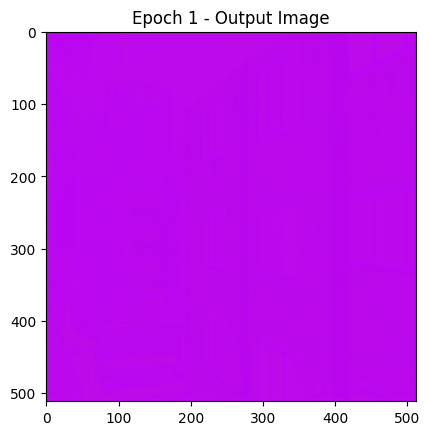

Epoch  1: zero_grad(): loss= 3.7331 output_mean= 0.0400 target_mean= 1.1617


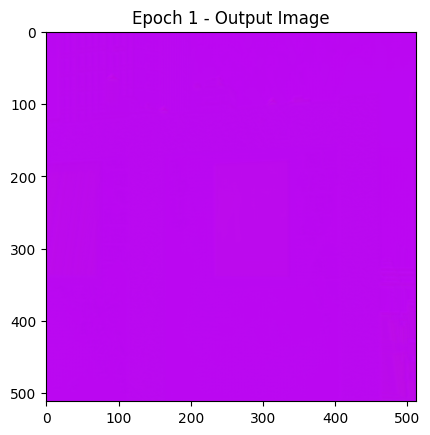

Epoch  1: zero_grad(): loss= 2.8029 output_mean= 0.0399 target_mean= 0.8724


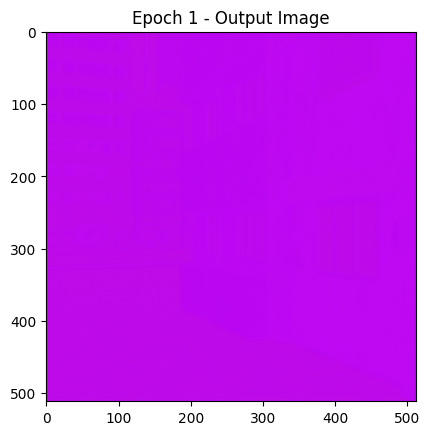

Epoch  1: zero_grad(): loss= 3.6148 output_mean= 0.0402 target_mean= 1.1252


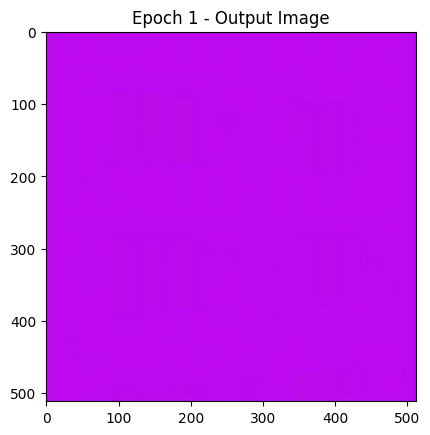

Epoch  1: zero_grad(): loss= 3.5743 output_mean= 0.0401 target_mean= 1.1124


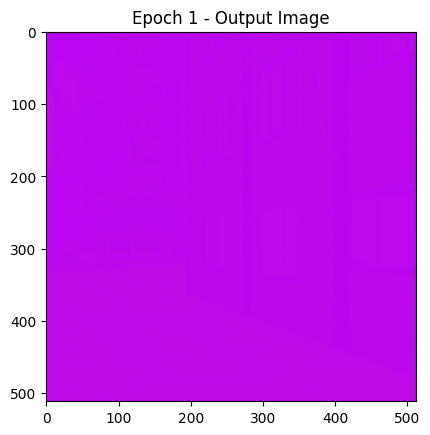

Epoch  1: zero_grad(): loss= 4.4635 output_mean= 0.0399 target_mean= 1.3891


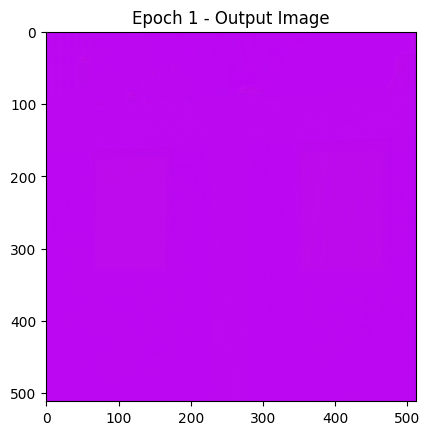

Epoch  1: zero_grad(): loss= 2.1055 output_mean= 0.0400 target_mean= 0.6554


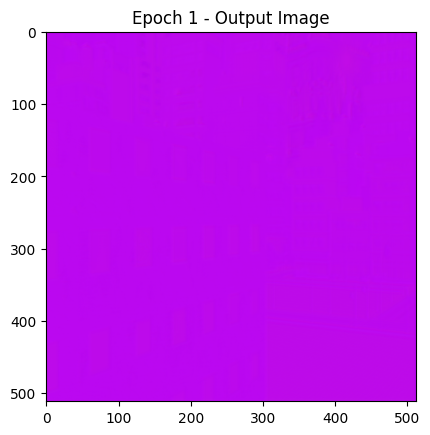

Epoch  1: zero_grad(): loss= 1.8929 output_mean= 0.0399 target_mean= 0.5894


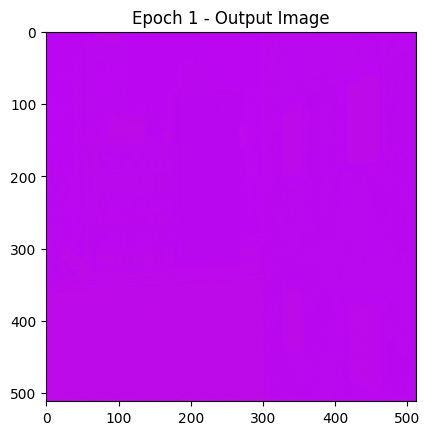

Epoch  1: zero_grad(): loss= 3.5705 output_mean= 0.0404 target_mean= 1.1117


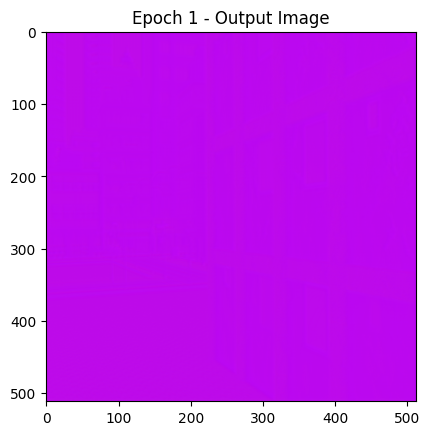

Epoch  1: zero_grad(): loss= 1.9280 output_mean= 0.0398 target_mean= 0.6001


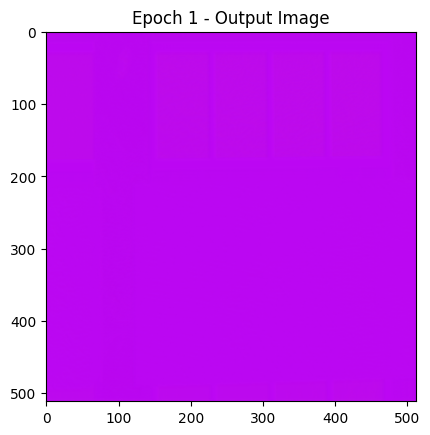

Epoch  1: zero_grad(): loss= 3.9307 output_mean= 0.0400 target_mean= 1.2232


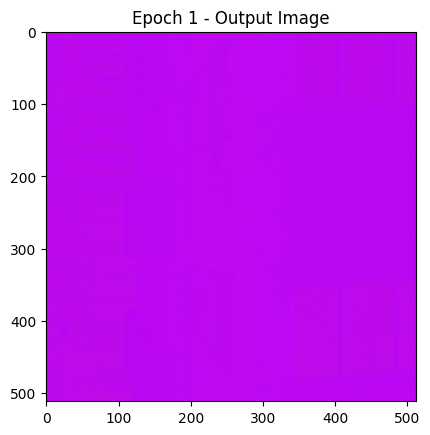

Epoch  1: zero_grad(): loss= 2.3756 output_mean= 0.0400 target_mean= 0.7394


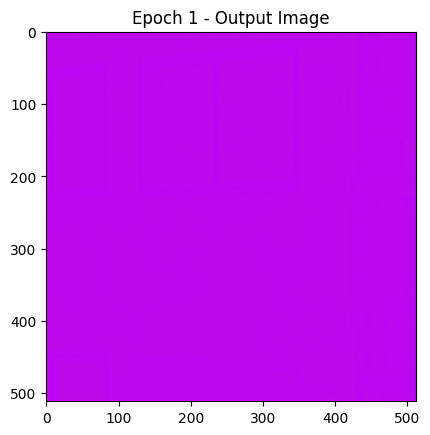

Epoch  1: zero_grad(): loss= 3.4981 output_mean= 0.0400 target_mean= 1.0889


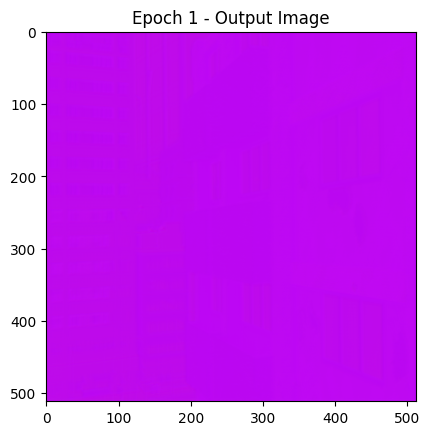

Epoch  1: zero_grad(): loss= 3.3685 output_mean= 0.0402 target_mean= 1.0485


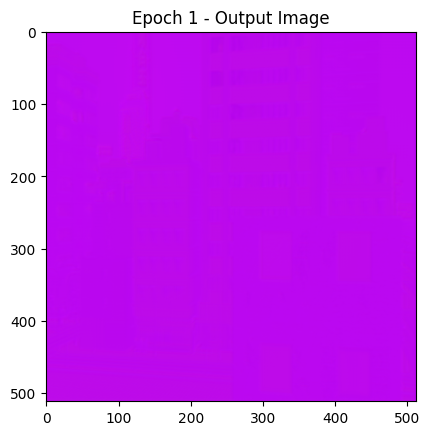

Epoch  1: zero_grad(): loss= 2.8981 output_mean= 0.0401 target_mean= 0.9023


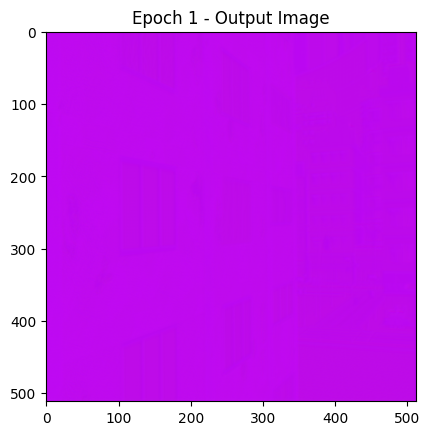

Epoch  1: zero_grad(): loss= 2.5884 output_mean= 0.0402 target_mean= 0.8057


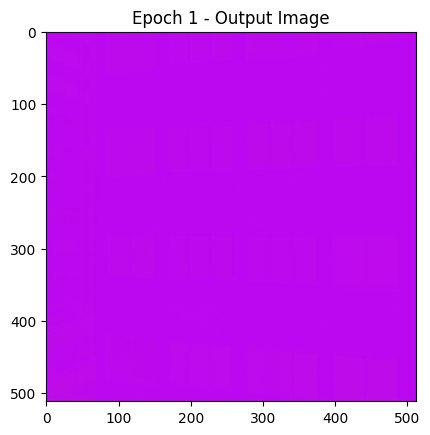

Epoch  1: zero_grad(): loss= 2.8653 output_mean= 0.0400 target_mean= 0.8918


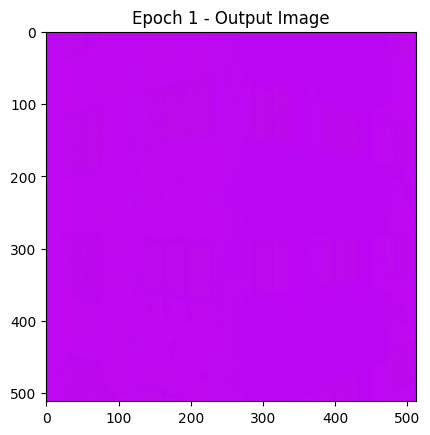

Epoch  1: zero_grad(): loss= 2.3504 output_mean= 0.0400 target_mean= 0.7318


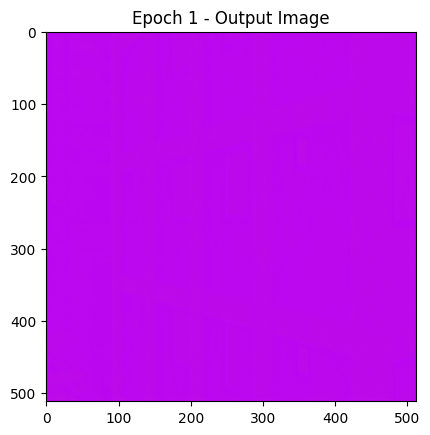

Epoch  1: zero_grad(): loss= 2.3996 output_mean= 0.0401 target_mean= 0.7470


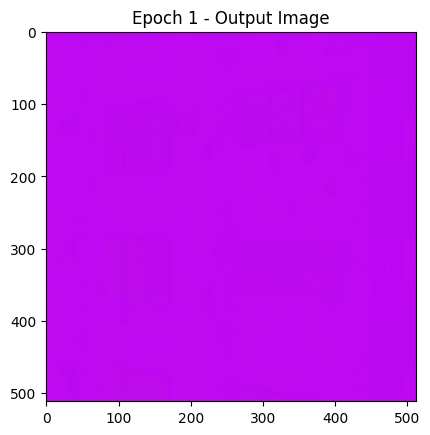

Epoch  1: zero_grad(): loss= 1.4344 output_mean= 0.0398 target_mean= 0.4465


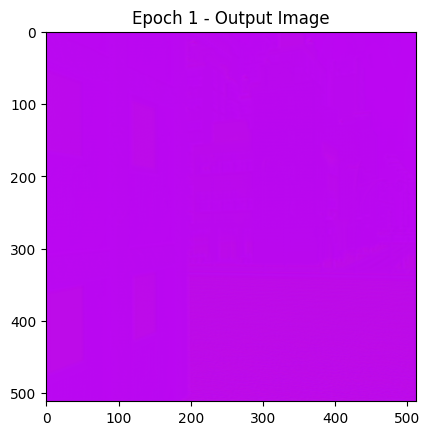

Epoch  1: zero_grad(): loss= 2.1246 output_mean= 0.0401 target_mean= 0.6612


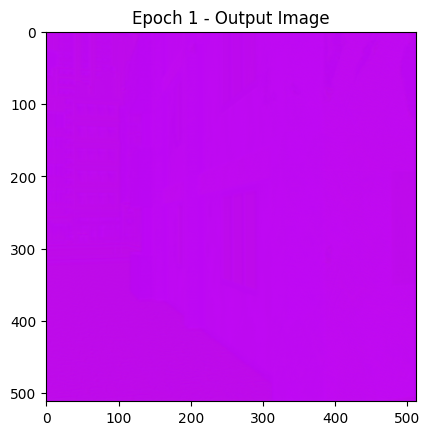

Epoch  1: zero_grad(): loss= 3.0302 output_mean= 0.0399 target_mean= 0.9432


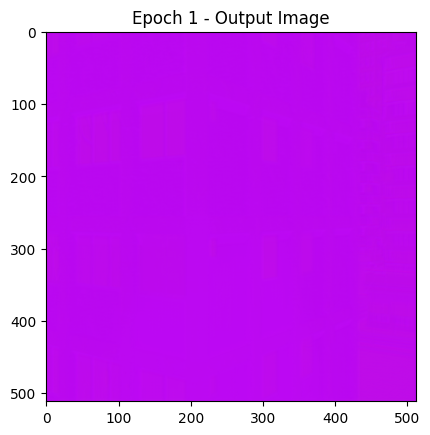

Epoch  1: zero_grad(): loss= 2.2619 output_mean= 0.0399 target_mean= 0.7041


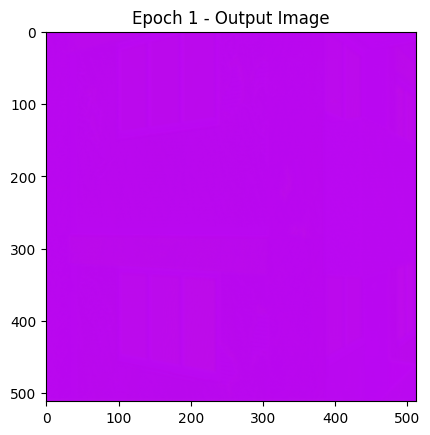

Epoch  1: zero_grad(): loss= 1.5104 output_mean= 0.0400 target_mean= 0.4702


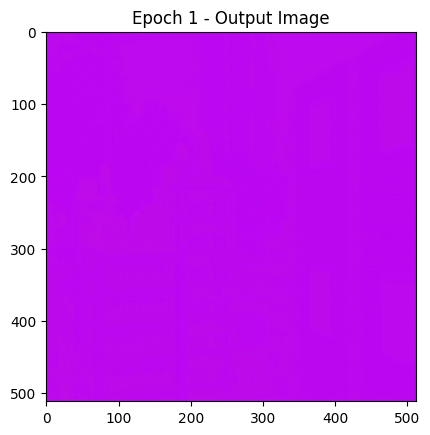

KeyboardInterrupt: 

In [82]:
# 4. Train model

epochs = 2

for epoch in range(1, epochs):

    for batch_id, (data,target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad() # zero the gradients
        output = model(data)    # apply network (Same as model.forward(data))
        loss = criterion(output, target)

        loss.backward()       # compute gradients
        optimizer.step()      # update weights

         # Print loss and statistics of output/target
        print('Epoch%3d: zero_grad(): loss=%7.4f output_mean=%7.4f target_mean=%7.4f' % 
              (epoch, loss.item(), output.mean().item(), target.mean().item()))

        # Convert the output tensor to a NumPy array and plot the image
        output_image = output[-1].cpu().detach().numpy()  # Get the first image in the batch
        output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

        # Convert from (C, H, W) to (H, W, C)
        output_image = np.transpose(output_image, (1, 2, 0))

        # Clip values to [0, 1] range (in case of any rounding issues)
        output_image = np.clip(output_image, 0, 1)
        
        # Display the output image (for visualization)
        plt.imshow(output_image)
        plt.title(f"Epoch {epoch} - Output Image")
        plt.show()